---
## <span style="color:orange"> Host Multiple TensorFlow Computer Vision Models using SageMaker Multi-Model Endpoint </span>
---
## <span style="color:black">Contents</span>
1. [Background](#Background)
1. [Setup](#Setup)
1. [Train Model 1 - CIFAR-10 Image Classification](#Train-Model-1---CIFAR-10-Image-Classification)
1. [Train Model 2 - Sign Language Image Classification](#Train-Model-2---Sign-Language-Image-Classification)
1. [Create a Multi-Model Endpoint](#Create-a-Multi-Model-Endpoint)
1. [Test Multi-Model Endpoint for Real Time Inference](#Test-Multi-Model-Endpoint-for-Real-Time-Inference)

### Background
In this notebook, we show how to host two computer vision models trained using the TensorFlow framework under one SageMaker multi-model endpoint.  For the first model, we train a smaller version of AlexNet CNN to classify images from the CIFAR-10 dataset. For the second model, we use a pretrained VGG16 CNN model pretrained on the ImageNet dataset and fine-tune on Sign Language Digits Dataset.

### Setup

 #### Prerequisites 
 Choose Kernel for this notebook.<br>
 Under `Kernel` tab at the top of this notebook &#8594; `Choose kernel`, select `conda_python3` 

In [1]:
%%capture

!pip install tensorflow==2.3.0

#### Imports 

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sagemaker.tensorflow.serving import TensorFlowModel
from sagemaker.multidatamodel import MultiDataModel
from tensorflow.keras.datasets import cifar10
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
from tensorflow.keras import utils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
import numpy as np
import sagemaker
import logging
import boto3
import time
import os

2022-11-03 19:59:06.893191: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/extras/CUPTI/lib64:/usr/local/cuda-11.0/lib:/usr/local/cuda-11.0/efa/lib:/opt/amazon/efa/lib:/opt/amazon/efa/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:
2022-11-03 19:59:06.893228: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Setup Logger

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [4]:
logger.info(f'[Using TensorFlow version: {tf.__version__}]')
logger.info(f'[Using SageMaker version: {sagemaker.__version__}]')

[Using TensorFlow version: 2.3.0]
[Using SageMaker version: 2.110.0]


#### Seed for Reproducability

In [5]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

#### Create Roles, Sessions and Data Locations

In [6]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.3.0'
BUCKET = sagemaker.Session().default_bucket()
PREFIX = 'cv-models'

### Train Model 1 - CIFAR-10 Image Classification

<p align="justify">First, we will train a Convolutional Neural Network (CNN) model to classify images from the CIFAR-10 dataset. Image classification is the task of assigning a label to an image, from a predefined set of categories. CIFAR-10 is an established CV dataset used for object recognition. It is a subset of the 80 Million Tiny Images dataset and consists of 60,000 (32x32) color images containing 1 of 10 object classes, with 6,000 images per class.</p>

#### a) Load Data

The first step is to load the pre-shuffled CIFAR-10 dataset into our train and test objects. Luckily, Keras provides the CIFAR dataset for us to load using the `load_data()` method. All we have to do is import keras.datasets and then load the data.

In [7]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


In [8]:
logger.info(f'X_train Shape: {X_train.shape}')
logger.info(f'y_train Shape: {y_train.shape}')
logger.info(f'X_test Shape : {X_test.shape}')
logger.info(f'y_test Shape : {y_test.shape}')

X_train Shape: (50000, 3, 32, 32)
y_train Shape: (50000, 1)
X_test Shape : (10000, 3, 32, 32)
y_test Shape : (10000, 1)


#### b) Data Exploration

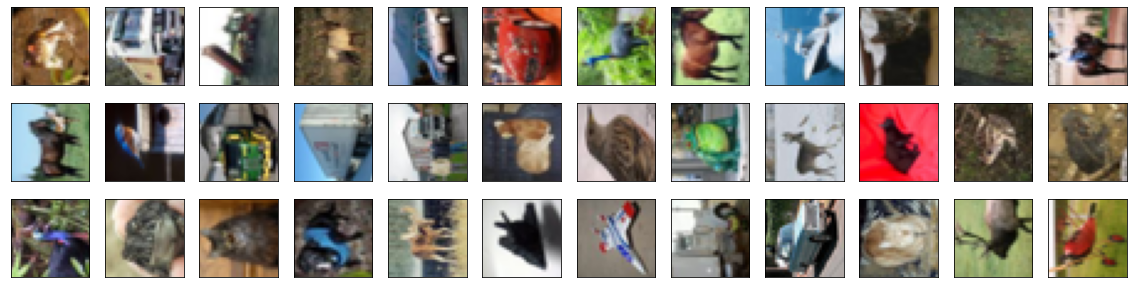

In [9]:
fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_train[i].T))

#### c) Data Preparation

##### Rescale 
Rescales the images by dividing the pixel values by 255: [0,255] ⇒ [0,1]

In [10]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

##### One Hot Encode Target Labels
One-hot encoding is a process by which categorical variables are converted into a numeric form. One-hot encoding converts the (1 × n) label vector to a label matrix of dimensions (10 × n), where n is the number of sample images. So, if we have 1,000 images in our dataset, the label vector will have the dimensions (1 × 1000). After one-hot encoding, the label matrix dimensions will be (1000 × 10). That’s why, when we define our network architecture in the next step, we will make the output softmax layer contain 10 nodes, where each node represents the probability of each class we have.

In [11]:
num_classes = len(np.unique(y_train))
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

##### Split Data
Break original train set further into train and validation sets.

In [12]:
X_train, X_validation = X_train[500:], X_train[:500]
y_train, y_validation = y_train[500:], y_train[:500]

In [47]:
X_train.shape

(49500, 3, 32, 32)

##### Save to Local

Create a local `data/cifar_10` directory to save the datasets.

In [13]:
DATASET_PATH = './data/cifar_10'

In [14]:
os.makedirs(DATASET_PATH, exist_ok=True)

Save train, validation and test sets to local `data` directory

In [15]:
np.save(f'{DATASET_PATH}/X_train.npy', X_train)
np.save(f'{DATASET_PATH}/y_train.npy', y_train)
np.save(f'{DATASET_PATH}/X_validation.npy', X_validation)
np.save(f'{DATASET_PATH}/y_validation.npy', y_validation)
np.save(f'{DATASET_PATH}/X_test.npy', X_test)
np.save(f'{DATASET_PATH}/y_test.npy', y_test)

##### Copy Datasets to S3
Copy train, validation and test sets from the local dir to S3, since SageMaker expects datasets to be in S3 for training.

In [16]:
!aws s3 cp ./{DATASET_PATH}/X_train.npy s3://{BUCKET}/{PREFIX}/cifar_10/train/
!aws s3 cp ./{DATASET_PATH}/y_train.npy s3://{BUCKET}/{PREFIX}/cifar_10/train/
!aws s3 cp ./{DATASET_PATH}/X_validation.npy s3://{BUCKET}/{PREFIX}/cifar_10/validation/
!aws s3 cp ./{DATASET_PATH}/y_validation.npy s3://{BUCKET}/{PREFIX}/cifar_10/validation/
!aws s3 cp ./{DATASET_PATH}/X_test.npy s3://{BUCKET}/{PREFIX}/cifar_10/test/
!aws s3 cp ./{DATASET_PATH}/y_test.npy s3://{BUCKET}/{PREFIX}/cifar_10/test/

upload: data/cifar_10/X_train.npy to s3://sagemaker-us-east-1-622343165275/cv-models/cifar_10/train/X_train.npy
upload: data/cifar_10/y_train.npy to s3://sagemaker-us-east-1-622343165275/cv-models/cifar_10/train/y_train.npy
upload: data/cifar_10/X_validation.npy to s3://sagemaker-us-east-1-622343165275/cv-models/cifar_10/validation/X_validation.npy
upload: data/cifar_10/y_validation.npy to s3://sagemaker-us-east-1-622343165275/cv-models/cifar_10/validation/y_validation.npy
upload: data/cifar_10/X_test.npy to s3://sagemaker-us-east-1-622343165275/cv-models/cifar_10/test/X_test.npy
upload: data/cifar_10/y_test.npy to s3://sagemaker-us-east-1-622343165275/cv-models/cifar_10/test/y_test.npy


#### d) Create Training Inputs 
Using the S3 locations of the datasets we saved in the previous step, create pointers to these datasets using the `TrainingInput`class from the SageMaker SDK.

In [17]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar_10/train', 
                            distribution='FullyReplicated', 
                            content_type='npy')
validation_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar_10/validation', 
                                 distribution='FullyReplicated', 
                                 content_type='npy')
test_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/cifar_10/test', 
                           distribution='FullyReplicated', 
                           content_type='npy')

In [18]:
inputs = {'train': train_input, 'val': validation_input, 'test': test_input}

#### e) Define Model Architecture & create Training Script

We will build a small CNN consisting of three convolutional layers and two dense layers.<br>
<b>Note:</b> We will use the ReLU activation function for all the hidden layers. In the last dense layer, we will use a softmax activation function with 10 nodes to return an array of 10 probability scores (summing to 1). Each score will be the probability that the current image belongs to our 10 image classes.

In [41]:
!pygmentize cifar_train.py

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
import tensorflow as tf
import numpy as np
import argparse
import logging
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Seed for Reproducability 
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Setup Logger
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())


def parse_args():
    parser = argparse.ArgumentParser() 
    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, default=os.environ.get('SM_CHANNEL

#### f) Create a TensorFlow Estimator & fit the Model

In [42]:
model_name = 'cifar-10'
hyperparameters = {'epochs': 1}
estimator_parameters = {'entry_point':'cifar_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'hyperparameters': hyperparameters,
                        'output_path': f's3://{BUCKET}/{PREFIX}/cifar_10/out',
                        'base_job_name': f'mme-cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}
estimator_1 = TensorFlow(**estimator_parameters)

In [43]:
estimator_1.fit(inputs, wait=False, logs=True)

### Train Model 2 - Sign Language Image Classification

#### a) Load Data

In [29]:
train_path  = './data/sign_language/train'
validation_path  = './data/sign_language/validation'
test_path  = './data/sign_language/test'

#### b) Data Exploration

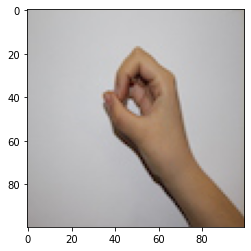

In [30]:
img = mpimg.imread(f'{train_path}/0/IMG_1118.JPG')
plt.imshow(img)

In [31]:
img.shape

(100, 100, 3)

<p>ImageDataGenerator generates batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).

In [32]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                         target_size=(224, 224), 
                                                         batch_size=10)

Found 1712 images belonging to 10 classes.


In [33]:
train_batches.next()[0][0].shape

(3, 224, 224)

Visualize random sample of images from `train_batches`

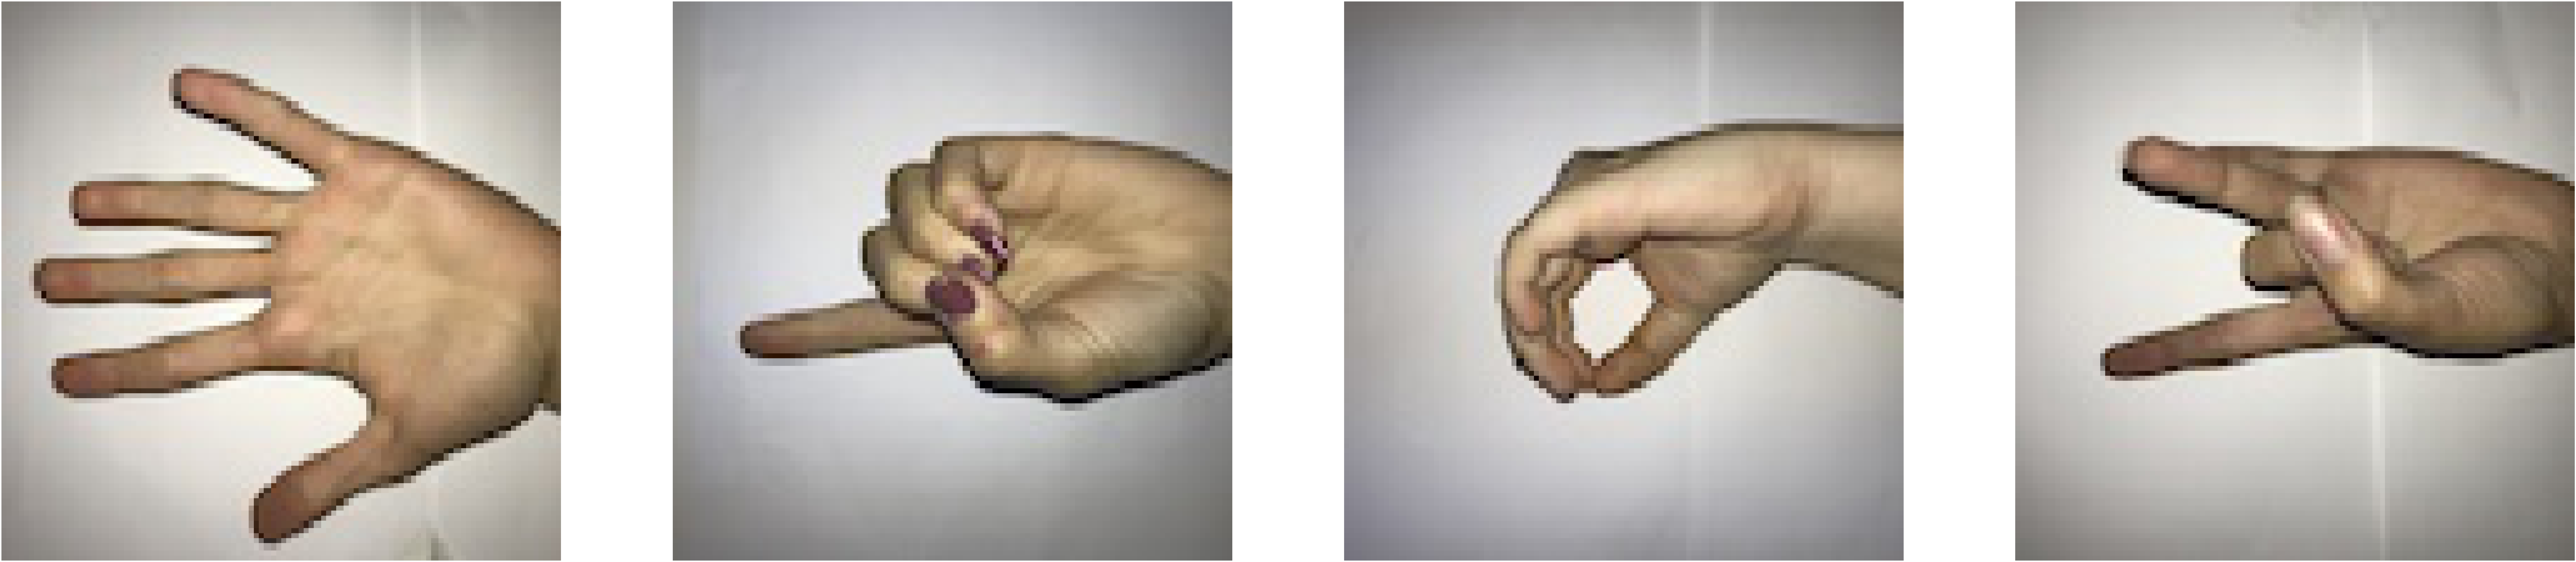

In [34]:
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(224, 224))
for row in rows:
    row.imshow(train_batches.next()[0][0].astype('int').T)
    row.axis('off')
plt.show()

#### c) Copy local data to S3 for SageMaker training

In [35]:
!aws s3 cp ./data/sign_language/ s3://{BUCKET}/{PREFIX}/sign_language/ --recursive

upload: data/sign_language/test/0/IMG_5572.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/0/IMG_5572.JPG
upload: data/sign_language/test/0/IMG_4159.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/0/IMG_4159.JPG
upload: data/sign_language/test/1/IMG_4497.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/1/IMG_4497.JPG
upload: data/sign_language/test/2/IMG_4727.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/2/IMG_4727.JPG
upload: data/sign_language/test/1/IMG_5340.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/1/IMG_5340.JPG
upload: data/sign_language/test/2/IMG_5594.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/2/IMG_5594.JPG
upload: data/sign_language/test/0/IMG_4976.JPG to s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/test/0/IMG_4976.JPG
upload: data/sign_language/test/1/IMG_5992.JPG to s3://sagemaker-us-east-1-6

#### d) Define Model Architecture & create Training Script

In [36]:
!pygmentize sign_language_train.py

from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import argparse
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)


def parse_args():
    parser = argparse.ArgumentParser() 
    # Hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, defau

#### f) Create a TensorFlow Estimator & fit the Model

In [38]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_language/train', 
                            distribution='ShardedByS3Key')
val_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/sign_language/validation', 
                          distribution='ShardedByS3Key')

In [39]:
model_name = 'sign-language'

hyperparameters = {'epochs': 1}
estimator_parameters = {'entry_point':'sign_language_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'hyperparameters': hyperparameters,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'output_path': f's3://{BUCKET}/{PREFIX}/sign_language/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}

estimator_2 = TensorFlow(**estimator_parameters)

In [40]:
estimator_2.fit({'train': train_input, 'val': val_input}, wait=False, logs=True)

### Create a Multi-Model Endpoint

#### a) Copy Trained Models to a common S3 Prefix

In [ ]:
tf_model_1 = estimator_1.model_data
output_1 = f's3://{BUCKET}/{PREFIX}/mme/cifar.tar.gz'

In [44]:
tf_model_2 = estimator_2.model_data
output_2 = f's3://{BUCKET}/{PREFIX}/mme/sign-language.tar.gz'

In [49]:
print(tf_model_2)
print(output_2)

s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/out/cv-sign-language-2022-11-03-21-02-45-562/output/model.tar.gz
s3://sagemaker-us-east-1-622343165275/cv-models/mme/sign-language.tar.gz


In [46]:
!mkdir -p models/model2
!aws s3 cp {tf_model_2} ./models/model2

download: s3://sagemaker-us-east-1-622343165275/cv-models/sign_language/out/cv-sign-language-2022-11-03-21-02-45-562/output/model.tar.gz to models/model2/model.tar.gz


In [53]:
PREFIX

'cv-models'

In [57]:
# Create 100 copies of this model
import sagemaker

sess = sagemaker.Session()
s3_bucket = sess.default_bucket()  # Replace with your own bucket name if needed
print(s3_bucket)

# Cell 06
import boto3

s3 = boto3.client("s3")
with open("models/model2/model.tar.gz", "rb") as f:
    # - s3://{BUCKET}/{PREFIX}/mme/sign-language.tar.gz
    s3.upload_fileobj(f, s3_bucket, f"{PREFIX}/mme/sign-language.tar.gz")

for i in range(0, 5):
    with open("models/model2/model.tar.gz", "rb") as f:
        # - s3://{BUCKET}/{PREFIX}/mme/sign-language-0.tar.gz
        s3.upload_fileobj(f, s3_bucket, f"{PREFIX}/mme/sign-language-{i}.tar.gz")

print("Models:uploaded and ready for use")
!aws s3 ls s3://{s3_bucket}/{PREFIX}/mme/
!aws s3 ls {output_2}

sagemaker-us-east-1-622343165275
Models:uploaded and ready for use
2022-11-04 01:18:26  104719978 sign-language-0.tar.gz
2022-11-04 01:18:27  104719978 sign-language-1.tar.gz
2022-11-04 01:18:28  104719978 sign-language-2.tar.gz
2022-11-04 01:18:29  104719978 sign-language-3.tar.gz
2022-11-04 01:18:30  104719978 sign-language-4.tar.gz
2022-11-04 01:18:25  104719978 sign-language.tar.gz
2022-11-04 01:18:25  104719978 sign-language.tar.gz


In [ ]:
# -- !aws s3 cp {tf_model_1} {output_1}
# !aws s3 cp {tf_model_2} {output_2}

#### b) Essentials

In [58]:
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

'2022-11-04-01-19-04'

In [60]:
IMAGE_URI = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04'
model_data_prefix = f's3://{BUCKET}/{PREFIX}/mme/'
model_data_prefix

's3://sagemaker-us-east-1-622343165275/cv-models/mme/'

In [65]:
!aws s3 ls {model_data_prefix}

2022-11-04 01:18:26  104719978 sign-language-0.tar.gz
2022-11-04 01:18:27  104719978 sign-language-1.tar.gz
2022-11-04 01:18:28  104719978 sign-language-2.tar.gz
2022-11-04 01:18:29  104719978 sign-language-3.tar.gz
2022-11-04 01:18:30  104719978 sign-language-4.tar.gz
2022-11-04 01:18:25  104719978 sign-language.tar.gz


#### Deploy multi model end point

In [67]:
# Cell 12
import boto3
from sagemaker import get_execution_role

sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client(service_name="sagemaker-runtime")

account_id = boto3.client("sts").get_caller_identity()["Account"]
region = boto3.Session().region_name

role = get_execution_role()
print(role)

arn:aws:iam::622343165275:role/service-role/AmazonSageMaker-ExecutionRole-20220208T115633


#### Create Model

model_url must point to the prefix under which the models are stored so like with the "/" at end

s3://s3_bucket/cv-models/mme/

In [68]:
# Cell 13
from time import gmtime, strftime

model_name = "mme-tensorflow-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
container = '763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04'

instance_type = "ml.m5.xlarge"

print("Model name: " + model_name)
print("Model data Url: " + model_data_prefix)
print("Container image: " + container)

container = {"Image": container, "ModelDataUrl": model_data_prefix, "Mode": "MultiModel"}

create_model_response = sm_client.create_model(
    ModelName=model_name, ExecutionRoleArn=role, Containers=[container]
)

print("Model ARN: " + create_model_response["ModelArn"])

Model name: mme-tensorflow-2022-11-04-03-04-41
Model data Url: s3://sagemaker-us-east-1-622343165275/cv-models/mme/
Container image: 763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04
Model ARN: arn:aws:sagemaker:us-east-1:622343165275:model/mme-tensorflow-2022-11-04-03-04-41


#### Create end point config

In [69]:
# Cell 14
endpoint_config_name = model_name # - keep the name the same across for ease of tracking
print("Endpoint config name: " + endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint config ARN: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint config name: mme-tensorflow-2022-11-04-03-04-41
Endpoint config ARN: arn:aws:sagemaker:us-east-1:622343165275:endpoint-config/mme-tensorflow-2022-11-04-03-04-41


#### Create end point

In [70]:
%%time
# Cell 15

import time

endpoint_name = model_name # - keep the name the same across for ease of tracking
print("Endpoint name: " + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)
print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Endpoint Status: " + status)

print("Waiting for {} endpoint to be in service...".format(endpoint_name))
waiter = sm_client.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=endpoint_name)

print("Created {} endpoint is in Service and read to invoke ...".format(endpoint_name))

Endpoint name: mme-tensorflow-2022-11-04-03-04-41
Endpoint Arn: arn:aws:sagemaker:us-east-1:622343165275:endpoint/mme-tensorflow-2022-11-04-03-04-41
Endpoint Status: Creating
Waiting for mme-tensorflow-2022-11-04-03-04-41 endpoint to be in service...
Created mme-tensorflow-2022-11-04-03-04-41 endpoint is in Service and read to invoke ...
CPU times: user 60 ms, sys: 3.53 ms, total: 63.6 ms
Wall time: 2min


#### Invoke the end point

In [76]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np

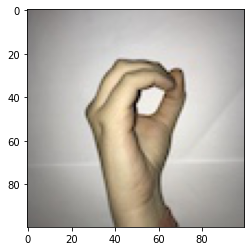

In [77]:
test_path  = './data/sign_language/test'
img = mpimg.imread(f'{test_path}/0/IMG_4159.JPG')
plt.imshow(img)

In [78]:

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [82]:
data = path_to_tensor(f'{test_path}/0/IMG_4159.JPG')
payload = {'instances': data}
payload
print(type(payload))
print(type(data))

<class 'dict'>
<class 'numpy.ndarray'>


In [98]:
# Cell 16
from datetime import datetime
import time
import json

data = np.array(data)
payload = json.dumps(data.tolist())

print(type(payload))

for i in range(0, 2):
    start_time = datetime.now()
    response = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        TargetModel=f"sign-language-{i}.tar.gz",
        Body=payload
    )
    result = json.loads(response['Body'].read().decode())
    #res = result['predictions']
    time_delta = (datetime.now()-start_time).total_seconds() * 1000 
    time_delta = "{:.2f}".format(time_delta)
    
    print(f'Time={time_delta} --- > ::{len(result)}')

<class 'str'>
Time=1119.87 --- > ::1
Time=1114.18 --- > ::1


In [89]:
result.keys()

dict_keys(['error'])

In [95]:
print(response.keys())
response['Body'].read().decode()
response['ResponseMetadata']

dict_keys(['ResponseMetadata', 'ContentType', 'InvokedProductionVariant', 'Body'])


{'RequestId': '319ae63f-81f9-4424-9f46-bc8c68b785a5',
 'HTTPStatusCode': 200,
 'HTTPHeaders': {'x-amzn-requestid': '319ae63f-81f9-4424-9f46-bc8c68b785a5',
  'x-amzn-invoked-production-variant': 'AllTraffic',
  'date': 'Fri, 04 Nov 2022 03:21:14 GMT',
  'content-type': '*/*',
  'content-length': '3625321'},
 'RetryAttempts': 0}

### Below uses Python SDK -- and this does not work 

#### c) Create a MultiDataModel using Model 1 

In [99]:
IMAGE_URI

'763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu-py37-ubuntu18.04'

In [101]:
model_2_2 = TensorFlowModel(model_data=output_2 , 
                          role=role, 
                          image_uri=IMAGE_URI)
model_2_2

In [102]:
mme_model = MultiDataModel(name=f'mme-tensorflow-{current_time}',
                     model_data_prefix=model_data_prefix,
                     model=model_2_2,
                     sagemaker_session=sess)
mme_model

#### d) Deploy Multi-Model Endpoint

In [103]:
predictor = mme_model.deploy(initial_instance_count=1,
                       instance_type='ml.m5.2xlarge',
                       endpoint_name=f'mme-tensorflow-{current_time}')

AttributeError: 'NoneType' object has no attribute 'default_bucket'

In [ ]:
list(mme.list_models())

### Test Multi-Model Endpoint for Real Time Inference 

#### a) Test Model-1 CIFAR Image Classification

In [ ]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from IPython.display import Image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
Image('./data/cifar_10/raw_images/airplane.png')

In [ ]:
img = load_img('./data/cifar_10/raw_images/airplane.png', target_size=(32, 32))
data = img_to_array(img)
data = data.astype('float32')
data = data / 255.0
data = data.reshape(1, 32, 32, 3)

In [ ]:
payload = {'instances': data}

In [ ]:
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'cifar.tar.gz'})

In [ ]:
predicted_label = CIFAR10_LABELS[np.argmax(y_pred)]
print(f'Predicted Label: [{predicted_label}]')

#### b) Test Model-2 Sign Language Classification

In [ ]:
test_path  = './data/sign_language/test'
img = mpimg.imread(f'{test_path}/0/IMG_4159.JPG')
plt.imshow(img)

In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [ ]:
data = path_to_tensor(f'{test_path}/0/IMG_4159.JPG')
payload = {'instances': data}

In [ ]:
y_pred = predictor.predict(data=payload, initial_args={'TargetModel': 'sign-language.tar.gz'})

In [ ]:
predicted_label = np.argmax(y_pred)
print(f'Predicted Label: [{predicted_label}]')